In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from collections import defaultdict
from gensim.models import Word2Vec

# Chargement des données
Les données sont partagées parmi plusieurs fichiers distincts. L'énoncé nous indique qu'on doit se servir uniquement des fichiers `orders_distance_stores_softmax` et `order_products__prior_specials`, mais il peut être pertinent pour l'analyse d'avoir accès à des informations de base sur les produits tels que le nom et le département de ceux-ci. Nous chargeons donc dans un premier temps tous les fichiers et les concaténons dans un tableau unique.

In [3]:
# Les produits, départements et allées ("aisles")
product_df = pd.read_csv("./data/products.csv")
aisles_df = pd.read_csv("./data/aisles.csv")
deparments_df = pd.read_csv("./data/departments.csv")
# Fusion des trois tableaux sur les clés primaires
products_df = product_df.merge(deparments_df, on="department_id", how="left")
products_df = products_df.merge(aisles_df, on="aisle_id", how="left")

# Informations sur les commandes ("orders")
dist_store_df = pd.read_csv("./data/orders_distance_stores_softmax.csv")
dist_store_df = dist_store_df.drop("Unnamed: 0", axis=1)
prod_prior_df = pd.read_csv("./data/order_products__prior_specials.csv")
prod_prior_df = prod_prior_df.drop("Unnamed: 0", axis=1)
orders_df = prod_prior_df.merge(dist_store_df, on="order_id")
#orders_df = orders_df.merge(products_df, on="product_id", how="left")

# Chargement des modèles Word2Vec
store_model = Word2Vec.load("./models/store_products.model")
product_model = Word2Vec.load("./models/products.model")
user_model = Word2Vec.load("./models/user_products.model")

# Preprocessing initial
Avant de s'attaquer à une sélection astucieuse des données, on peut déjà évacuer les données invalides si elles existent.

In [4]:
# Columns with unique values
uniq_cols = list(orders_df.columns[orders_df.nunique() == 1])

# Columns with invalid values
nan_cols = list(orders_df.columns[orders_df.isna().any()])

print("Unique columns: {}".format(uniq_cols))
print("NaN columns: {}".format(nan_cols))

# NaN values days_since_prior_order come from items bought twice on the same day.
# Replace the values with with zeros
orders_df["days_since_prior_order"] = orders_df["days_since_prior_order"].fillna(0)
# Remove columns with unique values
orders_df = orders_df.drop(uniq_cols, axis=1)

assert len(list(orders_df.columns[orders_df.nunique() == 1])) == 0, "There are still columns with unique values"
assert len(list(orders_df.columns[orders_df.isna().any()])) == 0, "There are still columns with NaN values"

Unique columns: ['eval_set']
NaN columns: ['days_since_prior_order']


In [5]:
n_products = orders_df["product_id"].nunique()
n_stores = orders_df["store_id"].nunique()
n_users = orders_df["user_id"].nunique()
n_orders = orders_df["order_id"].nunique()
n_departments = products_df["department_id"].nunique()
n_aisles = products_df["aisle_id"].nunique()
n_target_rows = int(len(orders_df) * 0.05)

print("Target number of rows: %d" % n_target_rows)
print("Current number of rows: %d" % len(orders_df))
print("Number of rows to remove: %d" % (len(orders_df) - n_target_rows))
basic_info_df = pd.DataFrame(
    [[n_products, n_departments, n_aisles, n_stores, n_users, n_orders]],
    columns=["# Products", "# Departments", "# Aisles", "# Stores", "# Users", "# Orders"]
)
basic_info_df

Target number of rows: 58615
Current number of rows: 1172312
Number of rows to remove: 1113697


,# Products,# Departments,# Aisles,# Stores,# Users,# Orders
0,24860,21,134,10,1374,136026


1    0.774435
0    0.225565
Name: reordered, dtype: float64


<AxesSubplot:>

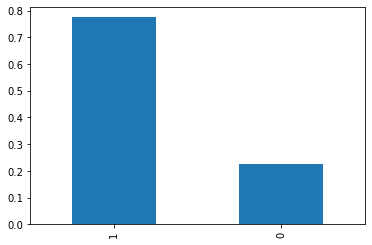

In [6]:
# Distribution des classes
print((orders_df["reordered"].value_counts() / len(orders_df)))
(orders_df["reordered"].value_counts() / len(orders_df)).plot.bar()

On constate un débalancement assez sévère des classes. On compte 907 879 (77.4435%) et 264 433 (22.5565%) commandes avec respectivement "reordered=True" et "reordered=False". Autrement dit, les commandes avec produits achetés à plusieurs reprises sont 3.43 fois plus nombreux que les produits nouveaux. Notre sous-échantillonage doit donc prendre en compte ce débalancement pour éviter de perdre trop d'instances "reordered=False".

Commençons par supprimer les instances aberrantes, c'est-à-dire:
- les clients avec peu de commandes différentes;
- les produits achetés par peu de clients différents;
- les produits présents dans peu de commandes différentes;

In [7]:
# Fonction utilitaire permettant de simuler une requête d'aggrégation SQL du genre
# SELECT col, COUNT(DISTINCT agg_col) AS n_agg_col FROM table_name GROUP BY col, agg_col
# Les commandes équivalentes avec l'API de Pandas génèrent beaucoup de doublons, ce qui nous force
# à implémenter cette solution.  
def count_distinct(dataframe, groupby_col, count_col):
    d = defaultdict()
    for row in dataframe.itertuples():
        uid = getattr(row, groupby_col)
        d[uid] = set()

    for row in dataframe.itertuples():
        uid = getattr(row, groupby_col)
        count_attr = getattr(row, count_col)
        d[uid].add(count_attr)

    df_count_col_name = "%s_count" % count_col
    d = {groupby_col: d.keys(), df_count_col_name: [len(v) for v in d.values()]}
    return pd.DataFrame.from_dict(d).sort_values(by=df_count_col_name)

In [8]:
users_n_order_df = count_distinct(orders_df, "user_id", "order_id")
users_n_order_df

,user_id,order_id_count
0,54901,99
920,71049,99
919,159610,99
918,190212,99
917,19612,99
...,...,...
454,150481,99
453,170217,99
452,31606,99
460,96192,99


In [9]:
products_n_order_df = count_distinct(orders_df, "product_id", "order_id")
products_n_order_df

,product_id,order_id_count
24859,17633,1
21220,36348,1
21221,19574,1
21223,29096,1
21224,33586,1
...,...,...
123,21903,9594
126,47209,10654
27,21137,13163
62,24852,16466


Le premier tableau nous informe que les données sont organisées de sorte que chaque utilisateur a exactement 99 commandes. Par conséquent, aucun consommateur ne doit être retiré. Cependant, plusieurs produits sont présents dans une unique commande. Ceux-ci peuvent potentiellement être considérés comme du bruit par nos algorithme de classification et doivent par conséquent être retirés. En ce sens, nous considérons seulement les produits se trouvant dans les 3e et 4e quartiles. Ainsi, on conserve les produits achetés à plusieurs reprises.

In [10]:
order_id_cnt_thres = products_n_order_df["order_id_count"].quantile(0.5)
n_products = products_n_order_df["product_id"].nunique()
mask = products_n_order_df["order_id_count"] < order_id_cnt_thres
to_remove = products_n_order_df[mask]["product_id"].unique()

print("Number of products: %d" % n_products)
print("Number of products to remove: %d" % len(to_remove))
print("Number of remaining products: %d" % (n_products - len(to_remove)))

n_rows_before = len(orders_df)
mask = orders_df["product_id"].isin(to_remove)
orders_df_prime = orders_df.drop(orders_df[mask].index)
n_rows_after = len(orders_df_prime)

products_n_users_df = count_distinct(orders_df_prime, "product_id", "user_id")

print("Number of rows to remove: %d" % mask.sum())
print("Number of remaining rows: %d" % n_rows_after)

user_id_cnt_thres = products_n_users_df["user_id_count"].quantile(0.25)
mask = products_n_users_df["user_id_count"] < user_id_cnt_thres
to_remove = products_n_users_df[mask]["product_id"].unique()

print("Number of products: %d" % n_products)
print("Number products to remove: %d" % len(to_remove))
print("Number of remaining products: %d" % (n_products - len(to_remove)))

n_rows_before = len(orders_df_prime)
mask = orders_df["product_id"].isin(to_remove)
orders_df_prime = orders_df_prime.drop(orders_df_prime[mask].index)
n_rows_after = len(orders_df_prime)
print("Number of rows to remove: %d" % mask.sum())
print("Number of remaining rows: %d" % n_rows_after)

Number of products: 24860
Number of products to remove: 11983
Number of remaining products: 12877
Number of rows to remove: 26086
Number of remaining rows: 1146226
Number of products: 24860
Number products to remove: 2740
Number of remaining products: 22120
Number of rows to remove: 37587
Number of remaining rows: 1108639


C:\Users\verdi\AppData\Local\Temp\ipykernel_3168\2057720334.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  orders_df_prime = orders_df_prime.drop(orders_df_prime[mask].index)


On s'assure que les modifications respectent les conditions, c'est-à-dire
- les consommateurs ont plusieurs commandes;
- les produits sont présents dans plusieurs commandes;
- les produits sont achetés par plusieurs consommateurs;

In [11]:
# Validation
users_n_order_df = count_distinct(orders_df_prime, "user_id", "order_id")
assert users_n_order_df["order_id_count"].min() >= order_id_cnt_thres, "Il reste des utilisateurs avec moins de %d commandes différentes." % order_id_cnt_thres

products_n_order_df = count_distinct(orders_df_prime, "product_id", "order_id")
assert products_n_order_df["order_id_count"].min() > user_id_cnt_thres, "Il reste des produits présents dans moins de %d commandes différentes." % user_id_cnt_thres

products_n_order_df = count_distinct(orders_df_prime, "product_id", "user_id")
assert products_n_order_df["user_id_count"].min() > 1, "Il reste des produits achetés seulement par un consommateur"

Après toutes ces opérations, les données sont réduites à 1 108 639 observations, ce qui représente environ 5% des données originales. Il reste donc 1 050 023 entrées à supprimer. Pour ce faire, nous proposons la stratégie suivante. On conserve d'abord toutes les instances de la classe minoritaire. On les ordonne ensuite en fonction du nombre de commandes par utilisateur. Finalement, on ajoute une instance originale par utilisateur de la liste obtenue de manière itérative jusqu'à ce que le nombre de lignes souhaitées (5% des données originales) soit obtenu.

Stratégie alternative: puisque nous avons un nombre de commandes élevées pour chacun des utilisateurs, on peut simplement conserver au plus $\tau = n\_lignes\_disponibles / n\_clients$  commandes différentes pour chacun des utilisateurs.

In [12]:
tau = int(np.ceil(n_target_rows / users_n_order_df["user_id"].nunique()))
assert users_n_order_df["order_id_count"].min() > tau, "Il existe un ou plusieurs clients avec un nombre de commandes inférieur à %d." % tau
print("Maximum number of orders per user: %d" % tau)

Maximum number of orders per user: 43


Comme tous les clients possèdent au minimum 42 commandes, cette stratégie devrait fonctionner. On doit être prudent et conserver un ratio des classes similaire dans notre procédure. Avec la loi forte des grands nombres, on sait qu'un sous-échantillonage aléatoire suffisamment grand devrait conserver le ratio original. Toutefois, pour nous en assurer, nous introduisons une procédure de type Las Vegas qui répète le sous-échantillonage jusqu'à ce le ratio soit respecté à un epsilon près. Une procédure aléatoire semble inappropriée car on cherche des paniers d'achat variés. Toutefois, considérant le faible nombre de paniers par consommateurs (99) et le nombre de paniers conservés (42), la probabilité de ne pas piger des produits variés est négligeable.

In [13]:
# On s'assure que le balancement des classes demeure le même
class_ratio_df = orders_df_prime["reordered"].value_counts() / len(orders_df_prime)
maj_cls_ratio = class_ratio_df[1]
min_cls_ratio = class_ratio_df[0]

ratio_is_respected, n_iter = False, 0
final_df = pd.DataFrame(columns=orders_df_prime.columns)
class_ratio_final_df = None

while not ratio_is_respected:
    final_df = pd.DataFrame(columns=orders_df_prime.columns)
    for tup in users_n_order_df.itertuples():
        # Masque pour filtrer l'utilisateur
        mask = orders_df_prime["user_id"] == tup.user_id
        # Échantillonnage aléatoire des commandes de l'utilisateur
        random_orders = orders_df_prime[mask].sample(tau)
        # Ajout des échantillons au tableau final
        final_df = pd.concat((final_df, random_orders))
    # Calcul du ratio des classes
    class_ratio_final_df = final_df["reordered"].value_counts() / len(final_df)
    ratio_is_respected = np.isclose(class_ratio_final_df[1], maj_cls_ratio, atol=1e-2) and np.isclose(class_ratio_final_df[0], min_cls_ratio, atol=1e-2)
    n_iter += 1

# On réordonne l'ordre des colonnes pour avoir les identifiants uniques au début et l'étiquette recherchée à la fin
first_cols = ["order_id", "product_id", "user_id", "store_id"]
last_col = ["reordered"]
other_cols = list(set(final_df.columns) - set(last_col) - set(first_cols))
final_df = final_df.loc[:, first_cols + other_cols + last_col]
final_df
# Sauvegarde des données finales
final_df.to_csv("./data/train_orders.csv", index=False)

print(class_ratio_final_df)
print("Processus complété avec %d itération(s)" % n_iter)


1    0.7756
0    0.2244
Name: reordered, dtype: float64
Processus complété avec 1 itération(s)


In [17]:
import gensim

def w2v_emb(df: pd.DataFrame, groupby_col: str, aggregate_col: str, n_epochs=5, embedding_size=10, num_negative_samples=7, min_count=1):
    df = df.groupby(groupby_col).apply(lambda x: x[aggregate_col].tolist())
    window_size = np.max(df.apply(len))

    # Entraînement du modèle
    return gensim.models.Word2Vec(
        sentences=df,
        sg=1, # 1 for skip-gram
        vector_size=embedding_size,
        window=window_size,
        min_count=min_count,
        workers=4,
        hs=0, # negative sampling will be used.
        negative=num_negative_samples,
        ns_exponent=0, # The exponent used to shape the negative sampling distribution.
        epochs=n_epochs
    )

product_model = w2v_emb(final_df, "order_id", "product_id")
user_model = w2v_emb(final_df, "product_id", "user_id")
store_model = w2v_emb(final_df, "product_id", "store_id")

SyntaxError: invalid syntax (3075153381.py, line 2)

In [18]:
from sklearn.preprocessing import MinMaxScaler

def add_embeddings(df: pd.DataFrame, w2v_model: Word2Vec, key: str):
    embeddings = []
    for row in df.itertuples():
        val = getattr(row, key)
        embed = w2v_model.wv.get_vector(val, norm=True)
        embeddings.append(embed)
    return np.array(embeddings)

def concat_df_cols(original_df: pd.DataFrame, to_add: np.ndarray, suffix: str):
    assert to_add.ndim == 2, "to_add must have exactly 2 dimensions" 
    to_add_df = pd.DataFrame(to_add, columns=["%s%d" % (suffix, i) for i in range(to_add.shape[1])])
    merged_df = pd.concat(
        (original_df.reset_index(), to_add_df),
        axis=1
    )
    return merged_df.drop("index", axis=1, errors="ignore")

final_df = concat_df_cols(final_df, add_embeddings(final_df, product_model, "product_id"), "P")
final_df = concat_df_cols(final_df, add_embeddings(final_df, user_model, "user_id"), "U")
final_df = concat_df_cols(final_df, add_embeddings(final_df, store_model, "store_id"), "S")
to_drop = ["order_id", "product_id", "user_id", "store_id"]
final_df = final_df.drop(to_drop, axis=1)

scaler = MinMaxScaler()
to_scale = ['special', 'order_dow', 'order_number', 'days_since_prior_order', 'order_hour_of_day', 'distance', 'add_to_cart_order', 'reordered']
final_df[to_scale] = scaler.fit_transform(final_df[to_scale])
final_df = final_df[final_df.drop("reordered", axis=1).columns.tolist() + ["reordered"]]
final_df.to_csv("./train_orders.csv", index=False)
data = final_df.to_numpy()

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torch.utils.data.dataset import T_co
from typing import Tuple
from sklearn.model_selection import train_test_split

class InstaCartDataset(Dataset):
    def __init__(self, data: np.array, val_ratio: float=0.1, test_ratio: float=0.33, batch_size: int = 32):
        self.name = self.__class__.__name__
        self.X = data[:, :-1]
        self.y = data[:, -1]
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.batch_size = batch_size

        self.n_instances = self.X.shape[0]
        self.in_features = self.X.shape[1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index) -> T_co:
        return self.X[index], self.y[index]

    def loaders(self, num_workers: int = 4, seed: int = None) -> Tuple[DataLoader, DataLoader, DataLoader]:
        X_train, X_val, y_train, y_val = train_test_split(self.X, self.y, test_size=self.val_ratio)
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=self.test_ratio)
        train_ldr = DataLoader(dataset=X_train, batch_size=self.batch_size, num_workers=num_workers)
        val_ldr = DataLoader(dataset=X_val, batch_size=self.batch_size, num_workers=num_workers)
        test_ldr = DataLoader(dataset=X_test, batch_size=self.batch_size, num_workers=num_workers)
        return train_ldr, val_ldr, test_ldr

    def split_train_test(self, test_pct: float = .5, label: int = 0, seed=None) -> Tuple[Subset, Subset]:
        assert (label == 0 or label == 1)

        if seed:
            torch.manual_seed(seed)

        # Fetch and shuffle indices of a single class
        label_data_idx = np.where(self.y == label)[0]
        shuffled_idx = torch.randperm(len(label_data_idx)).long()

        # Generate training set
        num_test_sample = int(len(label_data_idx) * test_pct)
        num_train_sample = int(len(label_data_idx) * (1. - test_pct))
        train_set = Subset(self, label_data_idx[shuffled_idx[num_train_sample:]])

        # Generate test set based on the remaining data and the previously filtered out labels
        remaining_idx = np.concatenate([
            label_data_idx[shuffled_idx[:num_test_sample]],
            np.where(self.y == int(not label))[0]
        ])
        test_set = Subset(self, remaining_idx)

        return train_set, test_set

In [ ]:
from torch import nn, optim
from tqdm import tqdm 


class MLP5(nn.Module):
    name = "MLP5"

    def __init__(self, in_features: int, n_class: int = 2, p_dropout=0.1):
        super(MLP5, self).__init__()

        self.in_layer = nn.Linear(in_features, 1024)
        self.h1 = nn.Linear(1024, 1024)
        self.h2 = nn.Linear(1024, 512)
        self.h3 = nn.Linear(512, 256)
        self.h4 = nn.Linear(256, 128)
        self.h5 = nn.Linear(128, 64)
        self.out_layer = nn.Linear(64, n_class - 1)
        self.dropout = nn.Dropout(p_dropout)
        self.relu = nn.ReLU()

    def forward(self, X: torch.Tensor):
        out = self.relu(self.in_layer(X))
        out = self.relu(self.h1(out))
        out = self.relu(self.h2(out))
        out = self.relu(self.h3(out))
        out = self.relu(self.h4(out))
        out = self.relu(self.h5(out))
        out = self.dropout(out)
        out = self.out_layer(out)
        return out

class MLP3(nn.Module):
    name = "MLP3"

    def __init__(self, in_features: int, n_class: int = 2, p_dropout=0.1):
        super(MLP3, self).__init__()

        self.in_layer = nn.Linear(in_features, 256)
        self.h2 = nn.Linear(256, 256)
        self.h3 = nn.Linear(256, 128)
        self.h4 = nn.Linear(128, 64)
        self.out_layer = nn.Linear(64, n_class - 1)
        self.dropout = nn.Dropout(p_dropout)
        self.relu = nn.ReLU()

    def forward(self, X: torch.Tensor):
        out = self.relu(self.in_layer(X))
        out = self.relu(self.h2(out))
        out = self.relu(self.h3(out))
        out = self.relu(self.h4(out))
        out = self.dropout(out)
        out = self.out_layer(out)
        return out


class MLP2(nn.Module):
    name = "MLP2"

    def __init__(self, in_features: int, n_class: int = 2, p_dropout=0.1):
        super(MLP2, self).__init__()

        self.h1 = nn.Linear(in_features, in_features // 2)
        self.h2 = nn.Linear(in_features // 2, in_features // 2)
        self.h3 = nn.Linear(in_features // 2, in_features // 4)
        self.h4 = nn.Linear(in_features // 4, n_class - 1)
        self.dropout = nn.Dropout(p_dropout)
        self.relu = nn.ReLU()

    def forward(self, X: torch.Tensor):
        out = self.relu(self.h1(X))
        out = self.relu(self.h2(out))
        out = self.relu(self.h3(out))
        out = self.relu(self.h4(out))
        out = self.relu(self.h5(out))
        out = self.dropout(out)
        out = self.h6(out)
        return out

class MLPTrainer:
    def __init__(self, model, optimizer, device: str = "cuda"):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optimizer
        self.loss_fn = nn.BCEWithLogitsLoss()
    
    def train(self, dataset_ldr, num_epochs):
        """
        Train the model for num_epochs times
        Args:
            num_epochs: number times to train the model
        """

        # Create pytorch's train data_loader
        train_loader = dataset_ldr

        # train num_epochs times
        for epoch in range(num_epochs):
            print("Epoch: {} of {}".format(epoch + 1, num_epochs))
            train_loss = 0.0
            self.cur_epoch = epoch

            with tqdm(range(len(train_loader))) as t:
                train_losses = []
                for i, data in enumerate(train_loader, 0):
                    # transfer tensors to selected device
                    train_inputs = data[0].to(self.device, dtype=torch.float)
                    train_labels = data[1].to(self.device, dtype=torch.long)
                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    # forward pass
                    train_outputs = self.model(train_inputs)
                    # compute loss
                    loss = self.loss_fn(train_outputs, train_labels)

                    # Use autograd to compute the backward pass.
                    loss.backward()
                    self.cur_loss = loss.item()
                    self.optimizer.step()

                    # Save losses for plotting purposes
                    train_losses.append(loss.item())

                    # print metrics along progress bar
                    train_loss += loss.item()
                    t.set_postfix(loss='{:05.3f}'.format(train_loss / (i + 1)))
                    t.update()
    
            # evaluate the model on validation data after each epoch
            self.metric_values['train_loss'].append(np.mean(train_losses))

In [ ]:
dataset = InstaCartDataset(data)
device = "cuda" if torch.cuda.is_available() else "cpu"
n_epochs = 200
train_ldr, val_ldr, test_ldr = dataset.loaders()
 
for model_cls in [MLP5, MLP3, MLP2]:
    model = model_cls(in_features=dataset.in_features)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    trainer = MLPTrainer(model=model, optimizer=optimizer, device=device)
    trainer.train(train_ldr, n_epochs)

## Le modèle

## L'entraînement

## L'évaluation

In [ ]:
# https://stackoverflow.com/questions/18138693/replicating-group-concat-for-pandas-dataframe
P = np.zeros((n_products, n_products))
order_prod_grouped_df = orders_df.groupby("order_id").apply(lambda x: list(x["product_id"]))

In [ ]:
order_prod_grouped_df